In [12]:
using Plots, ProgressMeter, CUDA

In [13]:
# Simulation parameters
nx=257
ny=nx
ncells=nx*ny

iterations=300000
savingperiod=1000
u0 = 0.1f0
ρ0 = 1.0f0
Re = 1000.0f0
ν = (nx-1)*u0/Re # Kinematic viscosity (0.005 <= ν <= 0.2)
τ = (6ν+1)/2

println("ν = ", ν, "  τ = ", τ)

# Directions
C=1; E=2; S=3; W=4; N=5; NE=6; SE=7; SW=8; NW=9
dx = Int8[0, 1, 0, -1, 0, 1, 1, -1, -1]
dy = Int8[0, 0, 1, 0, -1, -1, 1, 1, -1]

opposite = Int8[1, 4, 5, 2, 3, 8, 9, 6, 7]

# Geometry
geometry=zeros(Int, ny,nx) # Fluid/wall cells
geometry[1,:] .= 1         # top lid

geom_lin = vec(geometry)
;

ν = 0.025600001  τ = 0.5768


In [14]:
# Host side distribution functions
h_f = zeros(Float32, 9, ncells)
h_feq = similar(h_f)
h_fstar = similar(h_f)

# Initial distribution set at equilibrium
h_f[C, :] .= ρ0 * (4f0/9f0)
for d in (E, S, W, N)
    h_f[d, :] .= ρ0 * (1f0/9f0)
end
for d in (NE, SE, SW, NW)
    h_f[d, :] .= ρ0 * (1f0/36f0)
end

# Move data over to GPU
f = CuArray(h_f)
feq = CuArray(h_feq)
fstar = CuArray(h_fstar)
geom_d = CuArray(Int32.(geom_lin))

ρ_d = CuArray(zeros(Float32, ncells))
ux_d  = CuArray(zeros(Float32, ncells))
uy_d  = CuArray(zeros(Float32, ncells))

nx_d = Int32(nx)
ny_d = Int32(ny)
ncells_d = Int32(ncells)
u0_d = Float32(u0)
τ_d = Float32(τ)

# Precompute dx, dy, opposite arrays on GPU
dx_d = CuArray(Int8.(dx))
dy_d = CuArray(Int8.(dy))
opp_d = CuArray(Int8.(opposite))
;

In [15]:
# GPU kernels
function collision_kernel!(f::CuDeviceMatrix{Float32}, fstar::CuDeviceMatrix{Float32}, τ::Float32, ncells::Int32)
    tid = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if tid < 1 || tid > ncells
        return
    end
    
    idx = tid
    
    fC  = f[1, idx]; fE  = f[2, idx]; fS  = f[3, idx]; fW  = f[4, idx]; fN  = f[5, idx]
    fNE = f[6, idx]; fSE = f[7, idx]; fSW = f[8, idx]; fNW = f[9, idx]

    ρ = fC + fE + fS + fW + fN + fNE + fSE + fSW + fNW
    invρ = 1f0 / (ρ > 1f-12 ? ρ : 1f-12)
    ux = (fE - fW + fNE + fSE - fSW - fNW) * invρ
    uy = (fN - fS + fNE + fNW - fSE - fSW) * invρ

    u2 = ux*ux + uy*uy

    feqC = (4f0/9f0) * ρ * (1f0 - 1.5f0*u2)
    feqE = (1f0/9f0) * ρ * (1f0 + 3f0*ux + 4.5f0*ux*ux - 1.5f0*u2)
    feqS = (1f0/9f0) * ρ * (1f0 - 3f0*uy + 4.5f0*uy*uy - 1.5f0*u2)
    feqW = (1f0/9f0) * ρ * (1f0 - 3f0*ux + 4.5f0*ux*ux - 1.5f0*u2)
    feqN = (1f0/9f0) * ρ * (1f0 + 3f0*uy + 4.5f0*uy*uy - 1.5f0*u2)
    up = ux + uy
    um = ux - uy
    feqNE = (1f0/36f0) * ρ * (1f0 + 3f0*(up) + 4.5f0*(up*up) - 1.5f0*u2)
    feqSE = (1f0/36f0) * ρ * (1f0 + 3f0*(um) + 4.5f0*(um*um) - 1.5f0*u2)
    feqSW = (1f0/36f0) * ρ * (1f0 + 3f0*(-up) + 4.5f0*(up*up) - 1.5f0*u2)
    feqNW = (1f0/36f0) * ρ * (1f0 + 3f0*(-um) + 4.5f0*(um*um) - 1.5f0*u2)

    ω = 1f0 / τ
    invfactor = 1f0 - ω

    fstar[1, idx] = fC*invfactor + feqC*ω
    fstar[2, idx] = fE*invfactor + feqE*ω
    fstar[3, idx] = fS*invfactor + feqS*ω
    fstar[4, idx] = fW*invfactor + feqW*ω
    fstar[5, idx] = fN*invfactor + feqN*ω
    fstar[6, idx] = fNE*invfactor + feqNE*ω
    fstar[7, idx] = fSE*invfactor + feqSE*ω
    fstar[8, idx] = fSW*invfactor + feqSW*ω
    fstar[9, idx] = fNW*invfactor + feqNW*ω
    
    return
end

function streaming_kernel!(f::CuDeviceMatrix{Float32}, fstar::CuDeviceMatrix{Float32}, geom::CuDeviceVector{Int32}, nx::Int32, ny::Int32, 
        ncells::Int32, dx_d::CuDeviceVector{Int8}, dy_d::CuDeviceVector{Int8}, opp_d::CuDeviceVector{Int8}, u0::Float32)
    tid = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if tid < 1 || tid > ncells
        return
    end

    idx = tid
    j = (idx - 1) ÷ ny + 1
    i = (idx - 1) % ny + 1

    g = geom[idx]

    if g == 1
        # Lid cell, set f to equilibrium
        ρ = f[1, idx] + f[2, idx] + f[3, idx] + f[4, idx] + f[5, idx] + f[6, idx]+ f[7, idx]+ f[8, idx] + f[9, idx]
        ux = u0
        uy = 0f0
        u2 = ux*ux + uy*uy
        
        f[1, idx] = (4f0/9f0) * ρ * (1f0 - 1.5f0*u2)
        f[2, idx] = (1f0/9f0) * ρ * (1f0 + 3f0*ux + 4.5f0*ux*ux - 1.5f0*u2)
        f[3, idx] = (1f0/9f0) * ρ * (1f0 - 3f0*uy + 4.5f0*uy*uy - 1.5f0*u2)
        f[4, idx] = (1f0/9f0) * ρ * (1f0 - 3f0*ux + 4.5f0*ux*ux - 1.5f0*u2)
        f[5, idx] = (1f0/9f0) * ρ * (1f0 + 3f0*uy + 4.5f0*uy*uy - 1.5f0*u2)
        up = ux + uy
        um = ux - uy
        f[6, idx] = (1f0/36f0) * ρ * (1f0 + 3f0*(up) + 4.5f0*(up*up) - 1.5f0*u2)
        f[7, idx] = (1f0/36f0) * ρ * (1f0 + 3f0*(um) + 4.5f0*(um*um) - 1.5f0*u2)
        f[8, idx] = (1f0/36f0) * ρ * (1f0 + 3f0*(-up) + 4.5f0*(up*up) - 1.5f0*u2)
        f[9, idx] = (1f0/36f0) * ρ * (1f0 + 3f0*(-um) + 4.5f0*(um*um) - 1.5f0*u2)
        return
    end

    @inbounds begin
        for d in 1:9
            ddx = Int32(dx_d[d])
            ddy = Int32(dy_d[d])
            ni = i - ddy
            nj = j - ddx
            if ni >= 1 && ni <= ny && nj >= 1 && nj <= nx
                nidx = (nj - 1) * ny + ni
                f[d, idx] = fstar[d, nidx]
            else
                opp = Int(opp_d[d])
                f[d, idx] = fstar[opp, idx]
            end
        end
    end

    return
end

function saving_kernel!(ρ::CuDeviceVector{Float32}, ux::CuDeviceVector{Float32}, uy::CuDeviceVector{Float32}, f::CuDeviceMatrix{Float32}, ncells::Int32)
    tid = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if tid < 1 || tid > ncells
        return
    end
    idx = tid

    fC  = f[1, idx]; fE  = f[2, idx]; fS  = f[3, idx]; fW  = f[4, idx]; fN  = f[5, idx]
    fNE = f[6, idx]; fSE = f[7, idx]; fSW = f[8, idx]; fNW = f[9, idx]

    ρ_val = fC + fE + fS + fW + fN + fNE + fSE + fSW + fNW
    invρ = 1f0 / (ρ_val > 1f-12 ? ρ_val : 1f-12)
    ux_val = (fE - fW + fNE + fSE - fSW - fNW) * invρ
    uy_val = (fN - fS + fNE + fNW - fSE - fSW) * invρ

    ρ[idx] = ρ_val
    ux[idx] = ux_val
    uy[idx] = uy_val

    return
end
;

In [16]:
# kernel compilation helper
collision_gpu = @cuda threads=256 collision_kernel!(f, fstar, τ_d, Int32(ncells))

# main time loop
threads = 256
blocks = cld(ncells, threads)

u_list = []
@showprogress for it in 1:iterations
    @cuda threads=threads blocks=blocks collision_kernel!(f, fstar, τ_d, ncells_d)
    @cuda threads=threads blocks=blocks streaming_kernel!(f, fstar, geom_d, nx_d, ny_d, ncells_d, dx_d, dy_d, opp_d, u0_d)

    if (it % savingperiod) == 0
        @cuda threads=threads blocks=blocks saving_kernel!(ρ_d, ux_d, uy_d, f, ncells_d)

        CUDA.synchronize()

        ρ_h = Array(ρ_d)
        ux_h = Array(ux_d)
        uy_h = Array(uy_d)

        push!(u_list, sqrt.(reshape(ux_h, ny, nx).^2 + reshape(uy_h, ny, nx).^2))
    end
    
    if (it % 1000) == 0
        CUDA.synchronize()
    end
end
CUDA.synchronize()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


[ Info: Saved animation to /home/matspc/SSD/FMLB/TEMP.gif


Plots.AnimatedGif("/home/matspc/SSD/FMLB/TEMP.gif")
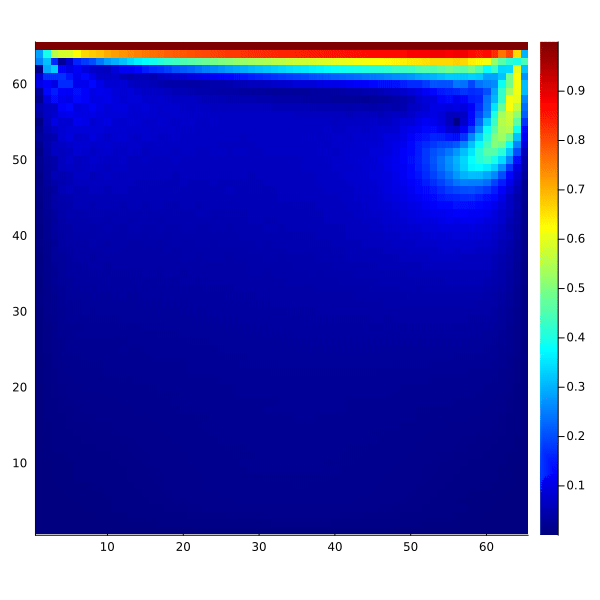

In [6]:
anim = @animate for t in 1:length(u_list)
    h = heatmap(reverse(u_list[t]./u0, dims=1), c=:jet, aspect_ratio=:equal)
    plot(h, size=(600,600))
end
gif(anim, "TEMP.gif", fps=10)

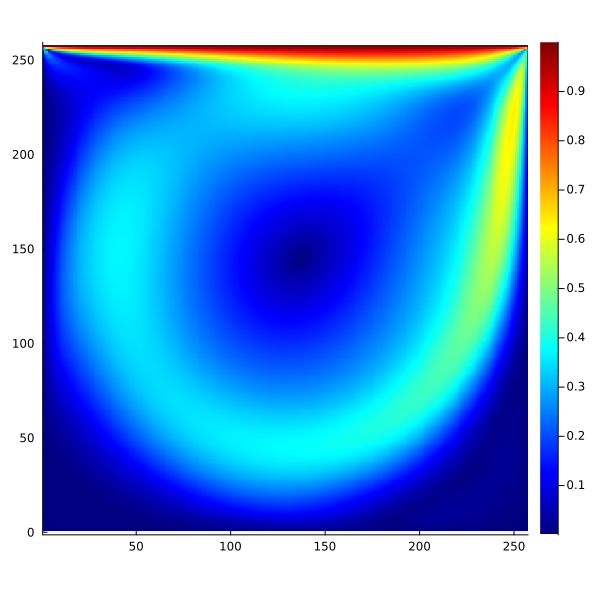

In [6]:
h = heatmap(reverse(u_list[end]./u0, dims=1), c=:jet, aspect_ratio=:equal)
plot(h, size=(600,600))